# STAT 301 Group Project Individual Assignment 2
## Author: Ethan Rajkumar, #55024616
## TA: Joey Hotz 
## Group Number: 24 






In [ ]:
suppressWarnings(suppressMessages({
  library(AER)
  library(boot)
  library(broom)
  library(caTools)
  library(caret)
  library(cowplot)
  library(dplyr)
  library(ggplot2)
  library(GGally)
  library(glmnet)
  library(grid)
  library(gridExtra)
  library(infer)
  library(modelr)
  library(pROC)
  library(repr)
  library(doParallel)
  library(reshape2)
  library(tidyverse)
}))


cat("All necessary packages have been loaded successfully.")



---
## Table of Contents
### [(0) Goals](#(0)-Goals) 
### [(1) Data Description & Exploratory Data Analysis and Visualization Reminders](#(1)-Data-Description-Exploratory-Data-Analysis-and-Visualization-Reminders) 
### [(2) Methods and Plan](#(2)-Methods-and-Plan)
### [(3) Implementation of Proposed Trained Models](#(3)-Implementation-of-Proposed-Trained-Models)
### [(4) Future Directions](#(4)-Future-Directions)
---


## (0) Goals

This notebook aims to:

1. Explore how logistic regression, ridge regression, and lasso regression can predict employee turnover and compare their performance, interpretability, and ability to identify key factors.  

2. Explain the forward selection process for these regression methods using the `employee` dataset.  

3. Provide code and results for logistic, ridge, and lasso regression models.



## (1) Data Description Exploratory Data Analysis and Visualization Reminders
The following is a reminder from the first individual assignment of the group assignment. Note that this time the question has been changed to: *How can logistic regression, logistic regression with ridge regularization, and logistic regression with lasso regularization be used to predict employee turnover? Furthermore, how do these methods compare in their ability to identify influential factors, provide model interpretability, and achieve predictive performance?*

In [ ]:
employee <- read.csv("data/Employee.csv")
head(employee)
# Function to count categories for any given variable in the dataset
count_categories <- function(data, variable) {
    data %>%
        group_by({{ variable }}) %>%   # Using {{ }} allows for non-standard evaluation, so you can pass column names as arguments
        tally() %>%
        arrange(desc(n))               # Optional: arrange in descending order of counts
}

# Example usage with Education
count_categories(employee, Education)

# Example usage with other variables (City, PaymentTier, Gender, EverBenched, LeaveOrNot)
count_categories(employee, City)
count_categories(employee, PaymentTier)
count_categories(employee, Gender)
count_categories(employee, EverBenched)
count_categories(employee, LeaveOrNot)

### Dataset Overview:
The Employees dataset provides anonymized data on company employees, including details such as educational attainment, job tenure, office location, salary tier, demographic attributes, and their work status within the organization. This dataset was gathered by the company’s Human Resources team and subsequently shared on Kaggle, a platform that hosts datasets and resources for data science professionals and enthusiasts.


#### Key Statistics:
- **Total Observations**: 4,653 employees
- **Total Variables**: 9 variables, each contributing to potential insights on employee demographics, job role characteristics, and retention patterns.

#### Variables:
| Variable                     | Type         | Description                                                                                                         | Categories/Range                                                                                                       |
|------------------------------|--------------|---------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------|
| **Education**                | Categorical  | Highest level of education attained by the employee.                                                               | **Bachelors** (n = 3601), **Masters** (n = 873), **PhD** (n = 179)                                                    |
| **JoiningYear**              | Numerical    | Year the employee joined the organization, representing tenure.                                                     | 2012 to 2018                                                                                                           |
| **City**                     | Categorical  | City in which the employee works.                                                                                   | **Bangalore** (n = 2228), **Pune** (n = 1268), **New Delhi** (n = 1157)                                               |
| **PaymentTier**              | Categorical  | Salary tier or pay level of the employee.                                                                           | **3** (n = 3492) - lowest, **2** (n = 918) - mid-level, **1** (n = 243) - highest                                      |
| **Age**                      | Numerical    | Age of the employee.                                                                                                | 22 to 41                                                                                                               |
| **Gender**                   | Categorical  | Gender of the employee.                                                                                             | **Male** (n = 2778), **Female** (n = 1875)                                                                             |
| **EverBenched**              | Binary       | Indicates if the employee has ever been benched (i.e., had a period without assigned work).                         | **No** (n = 4175), **Yes** (n = 478)                                                                                   |
| **ExperienceInCurrentDomain**| Numerical    | Years of experience in the employee's current field before joining the company.                                     | 0 to 7                                                                                                                 |
| **LeaveOrNot**               | Binary       | Target variable indicating if the employee left the company.                                                        | **0** (n = 3053) - stayed, **1** (n = 1600) - left                                                                     |
#### Dataset Description:
This dataset offers a mix of demographic, employment, and behavioral information. Each record captures unique attributes for individual employees, enabling analysis of factors that may contribute to whether an employee stays with or leaves the company. Insights drawn from this data can help organizations understand key drivers of employee retention and guide HR policy improvements.


[Link to the Dataset](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset/data)



---


###  Question:

*"Which specific factors, such as age, payment tier, benching status, and experience, are statistically significant predictors of whether an employee will leave the organization? Additionally, how does each factor impact the likelihood of turnover?"*

---

### Explanation of the Question

- **Objective**: This question aims to identify specific factors (e.g., age, payment tier, benching status, experience) that significantly influence employee turnover, focusing on measurable predictors rather than general trends.
  
- **Predictive Focus**: By examining the statistical significance and effect size of each factor, we seek to pinpoint exactly which variables contribute most to an employee's likelihood of leaving.

- **Outcome**: This analysis will reveal which factors (such as low payment tier or benching status) are strongly associated with higher turnover and clarify the extent of each factor's impact on retention. These insights will enable targeted, data-driven retention strategies.

### Project Goals

1. Explore the relationship between specific predictors in the dataset and employee retention (`LeaveOrNot`).
   
2. Identify the key predictors associated with `LeaveOrNot` and train a predictive model to assess an employee's probability of leaving the organization.

3. Determine how this model holds in predicting probability of turnover.



### Exploratory Data Analysis and Visualization


### Data Preprocessing
We first split our dataset into training and testing dataset. This way we can choose a model in the training phase of our regression and test our model on our dataset. **We have already split this into `employee_test.csv` and `employee_train.csv`.**

In [ ]:
employee_train  <- read.csv("data/employee_train.csv")
employee_test <- read.csv("data/employee_test.csv") 

Now that the dataset has been split into `employee_train` and `employee_test`. Let's visualize `employee_train` by taking a look at the categorical variables and the box plot medians. 

In [ ]:
options(warn = -1)
# Ensure 'LeaveOrNot' is a factor for proper grouping
employee_train <- employee_train %>%
  mutate(LeaveOrNot = as.factor(LeaveOrNot))

# Calculate variance for each numerical variable by LeaveOrNot
numeric_vars <- employee_train %>% select(where(is.numeric), LeaveOrNot)

numeric_vars_names <- names(numeric_vars)

categorical_vars <- employee_train %>% select(-numeric_vars_names, -LeaveOrNot)
categorical_vars$LeaveOrNot <- employee_train$LeaveOrNot


### Cardinality Plots and Their Importance

Cardinality plots are valuable tools in data analysis for visualizing the distribution and diversity of categorical variables in relation to an outcome variable. By examining these variables across different levels of an outcome (such as `LeaveOrNot`), these plots help reveal patterns or imbalances that may indicate underlying trends, biases, or specific behaviors within groups that could influence the target variable. For example, if certain education levels or cities are predominantly associated with one outcome (like staying or leaving a company), this insight can support stakeholders in making data-driven decisions or refining models to better account for these relationships.


In [ ]:
cardinality_plots <- lapply(names(categorical_vars)[-ncol(categorical_vars)], function(var) {
  ggplot(categorical_vars, aes(x = .data[[var]], fill = LeaveOrNot)) +
    geom_bar(position = "fill") +
    labs(x = var, y = "Proportion") +
    theme_minimal()
})

grid.arrange(
  grobs = cardinality_plots, 
  ncol = 2,  # Adjust as needed for layout
  top = textGrob("Proportion of Categorical Variables by LeaveOrNot", 
                 gp = gpar(fontsize = 15, fontface = "bold"))  # Customize title size and style here
)

### Analysis of Cardinality Plots
In the plots, we observe the following patterns: individuals with a Master’s degree appear more likely to stay (indicated by a smaller proportion of `LeaveOrNot` equal to 1 in teal) compared to those with a Bachelor's or PhD. Employees in New Delhi show a slightly higher retention rate (a smaller teal section for `LeaveOrNot` equal to 1) compared to those in Bangalore and Pune. For `PaymentTier`, employees in tier 1 have a higher likelihood of staying, while those in tiers 2 and 3 show a larger proportion of individuals leaving. In terms of `Gender`, females have a marginally higher retention rate than males, as seen in a smaller proportion of teal in the `LeaveOrNot` equal to 1 category for females. Lastly, employees who have been benched (`EverBenched` set to "Yes") are more likely to leave, with a higher teal proportion in that category compared to those who haven’t been benched. These insights suggest that factors such as education level, payment tier, and benching status may significantly influence an employee’s decision to stay or leave, offering valuable direction for workforce retention strategies.


### Box Plots for Numeric Variables

Box plots are effective for visualizing the distribution, central tendency, and spread of numeric variables across different categories or outcomes. In this case, box plots show how numeric variables like `Joining Year`, `Age`, and `ExperienceInCurrentDomain` are distributed based on the "LeaveOrNot" factor. Each plot highlights the median, interquartile range (IQR), and potential outliers, which gives insight into differences in these variables for employees who stayed (0) versus those who left (1).


In [ ]:
box_plots <- lapply(names(numeric_vars)[-ncol(numeric_vars)], function(var) {
  ggplot(numeric_vars, aes(x = factor(LeaveOrNot), y = .data[[var]], fill = factor(LeaveOrNot))) +
    geom_boxplot() +
    theme_minimal()
})

grid.arrange(
  grobs = box_plots,
  ncol = 2,  # Adjust layout as needed
  top = textGrob("Box Plots of Numeric Variables by LeaveOrNot",
                 gp = gpar(fontsize = 15, fontface = "bold"))
)

### Anaylsis of Box Plots
In the box plots, we observe that employees with more recent `JoiningYear` show a slight tendency to leave, as indicated by a higher median joining year in the teal box for `LeaveOrNot` equal to 1 (left), while those who stayed tend to have an earlier `JoiningYear,` suggesting that longer tenure might correlate with higher retention. `Age` distributions are fairly similar across both groups, with a slightly younger median for employees who left, hinting that younger employees might be marginally more prone to leaving, though the difference is minimal. `ExperienceInCurrentDomain` also shows a similar distribution, with a slightly higher median experience for those who stayed, implying that more domain experience might be associated with a higher likelihood of staying, though this difference is subtle. These box plots reveal subtle trends in numeric variables related to employee retention, offering insights into workforce dynamics influenced by `JoiningYear`, `Age`, and `ExperienceInCurrentDomain`.


### Pairwise Plots 

Pairwise plots are useful in logistic regression because they help us understand the relationships, distributions, and potential correlations among predictor variables, as well as their association with the outcome variable. By visualizing these pairwise relationships, we can identify any collinearity or multicollinearity between predictors, which can negatively impact model performance if left unaddressed. Pairwise plots also reveal trends and patterns that might suggest which predictors are relevant to the outcome, allowing us to make more informed decisions about variable selection and transformations. 


In [ ]:
# Create ggpairs plot for all numeric variables
ggpairs(numeric_vars,
        aes(color = LeaveOrNot, fill = LeaveOrNot), 
        title = "Pairwise Relationships of Numeric Variables by LeaveOrNot",
        upper = list(continuous = wrap("cor", size = 4)), 
        lower = list(continuous = wrap("points", alpha = 0.3, size = 1)), 
        diag = list(continuous = wrap("densityDiag"))) 

Correlation values in the plot indicate that `Age` and `ExperienceInCurrentDomain` have negative relationships with `LeaveOrNot`, suggesting that younger employees and those with less domain experience are more likely to leave. Density plots reveal that employees who joined more recently (indicated by peaks in the most recent years) show a higher likelihood of leaving. Scatterplots and histograms help visualize the distribution and clustering within each variable, reinforcing that employees with an earlier `JoiningYear`, higher `Age`, and more `ExperienceInCurrentDomain` tend to stay (red section). The box plots further support these trends by illustrating higher medians for `JoiningYear`, `Age`, and `ExperienceInCurrentDomain` among employees who stayed. 


After exploring all eight input variables, we conclude that `Education`, `Gender`, `PaymentTier`, `City`, and `EverBenched` may be strong predictors of `LeaveOrNot`, while `Age`, `JoiningYear`, and `ExperienceInCurrentDomain` seem less relevant due to apparent multicollinearity. Since this is merely an exploration of the variables without conducting a proper logistic regression, ridge and lasso regression these conclusions are speculative.

Based on these insights, we will proceed to design models for logistic regression, lasso regression, and ridge regression.  


## (2) Methods and Plan

### Main Models Used 

For this analysis, I propose using **logistic regression** as the primary method to predict employee turnover (`LeaveOrNot`), complemented by **lasso regression** and **ridge regression** for variable selection and regularization. Below is an overview of the rationale, assumptions, advantages, and limitations of logistic regression.

### Why Logistic Regression?

1. **Binary Outcome**: Logistic regression is ideal for the binary target variable, `LeaveOrNot` (0 = stayed, 1 = left).
2. **Interpretability**: Coefficients provide insights into how predictors like education, tenure, and salary tier affect turnover.
3. **Baseline Model**: It serves as a straightforward baseline for comparison with regularized methods.

### Why Include Lasso and Ridge Regression?

- **Lasso Regression**: L1 regularization aids in identifying key predictors by shrinking some coefficients to zero, especially useful with correlated variables.
- **Ridge Regression**: L2 regularization addresses multicollinearity and reduces overfitting, ensuring a more robust model.

### Assumptions of Logistic Regression

1. **Linearity in Logit**: Predictors must relate linearly to the log-odds of the target variable.
2. **Independence**: Observations should be independent.
3. **No Perfect Multicollinearity**: Predictors should not be perfectly correlated, mitigated by lasso and ridge regression.

### Advantages

- **Interpretability**: Results are clear and actionable for understanding factors influencing turnover.
- **Strategic Insights**: Identifies significant predictors to inform HR policies and improve retention.
- **Baseline Comparison**: Serves as a foundation for evaluating more complex methods.

### Limitations

### Potential Limitations

1. **Linearity Assumption**: Logistic regression assumes a linear relationship between predictors and the log-odds of the outcome. Violations of this assumption can lead to model misspecification.

2. **Class Imbalance**: The dataset has a higher proportion of employees staying (n=3053) compared to those leaving (n=1600), potentially biasing predictions toward the majority class.

3. **Overfitting**: Including too many predictors without regularization can lead to overfitting. While ridge and lasso address this, careful tuning of their hyperparameters is essential to avoid under- or over-penalization.

4. **Optimization Bias**: Ridge and lasso regularization, may lead to optimization bias. This can result in overly optimistic estimates of AUC that do not generalize well to new, unseen data.

### Plan of Action 
The project workflow is shown below. Anything in blue is still yet to be completed. 

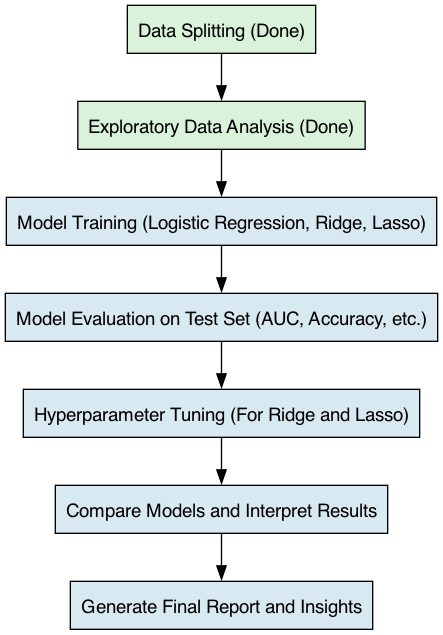

## (3) Implementation of Proposed Trained Models 

The purpose of this implementation is to train and compare three logistic regression models—base logistic regression, ridge regression, and lasso regression—on the training dataset to predict employee turnover (`LeaveOrNot`). 

In [ ]:
# Prepare the predictors and response for training
X <- 
    model.matrix(object = LeaveOrNot ~ .,
                 data = employee_train)[, -1]
y <- 
    as.matrix(employee_train$LeaveOrNot, ncol = 1)

The subsequent code evaluates and compares the performance of logistic regression, ridge regression, and lasso regression using 10-fold cross-validation (CV) on the `employee_train` dataset, with performance measured by the Area Under the Receiver Operating Characteristic Curve (AUC). Each fold functions as a test set, while the remaining data is used for training, ensuring a robust assessment of model performance. Logistic regression serves as a baseline model, ridge regression incorporates L2 regularization to address multicollinearity and prevent overfitting, and lasso regression applies L1 regularization to perform feature selection. The average AUC across all folds is computed for each model to summarize their effectiveness, with the results organized in a tibble for clarity and comparison.

In [ ]:
suppressWarnings({
  set.seed(20010527)
  num.folds <- 10
  folds <- createFolds(employee_train$LeaveOrNot, k = num.folds)

  # Logistic Regression Cross-Validation
  logistic_auc <- numeric(num.folds)
  for (fold in 1:num.folds) {
    train.idx <- setdiff(1:nrow(employee_train), folds[[fold]])
    test.idx <- folds[[fold]]
    
    logistic_model <- glm(LeaveOrNot ~ ., data = employee_train, subset = train.idx, family = "binomial")
    pred <- predict(logistic_model, newdata = employee_train[test.idx, ], type = "response")
    
    logistic_auc[fold] <- suppressMessages(auc(employee_train$LeaveOrNot[test.idx], pred))
  }
  logistic_cv_auc <- round(mean(logistic_auc), 7)

  # Ridge Regression Cross-Validation
  ridge_auc <- numeric(num.folds)
  for (fold in 1:num.folds) {
    train.idx <- setdiff(1:nrow(employee_train), folds[[fold]])
    test.idx <- folds[[fold]]
    
    ridge_model <- cv.glmnet(X[train.idx, ], y[train.idx], alpha = 0, family = "binomial", type.measure = "auc")
    pred <- predict(ridge_model, newx = X[test.idx, ], s = "lambda.min", type = "response")
    
    ridge_auc[fold] <- suppressMessages(auc(y[test.idx], pred))
  }
  ridge_cv_auc <- round(mean(ridge_auc), 7)

  # Lasso Regression Cross-Validation
  lasso_auc <- numeric(num.folds)
  for (fold in 1:num.folds) {
    train.idx <- setdiff(1:nrow(employee_train), folds[[fold]])
    test.idx <- folds[[fold]]
    
    lasso_model <- cv.glmnet(X[train.idx, ], y[train.idx], alpha = 1, family = "binomial", type.measure = "auc")
    pred <- predict(lasso_model, newx = X[test.idx, ], s = "lambda.min", type = "response")
    
    lasso_auc[fold] <- suppressMessages(auc(y[test.idx], pred))
  }
  lasso_cv_auc <- round(mean(lasso_auc), 7)

  # Create tibble for results
  results <- tibble(
    Model = c("Logistic Regression", "Ridge Regression", "Lasso Regression"),
    AUC = c(logistic_cv_auc, ridge_cv_auc, lasso_cv_auc)
  )
})

# Print the tibble
results

results_df = pd.DataFrame(results_data)


### Interpretation of Results
The AUC values on the training set indicate that logistic regression, ridge regression, and lasso regression perform similarly, with AUCs around 0.73. Logistic regression achieves the highest AUC on training data, but this advantage may not hold on a testing set due to potential overfitting. Regularized models like ridge and lasso regression could perform better on unseen data by addressing multicollinearity and reducing overfitting. However, evaluating the models on a testing set is essential to confirm their generalizability and ensure reliable conclusions.

## (4) Future Directions
The next steps are now to determine which specific models are used for Logistic, Ridge and Lasso then test these models using the testing dataset to compare the difference in models. This workflow is shown in the figure below. 

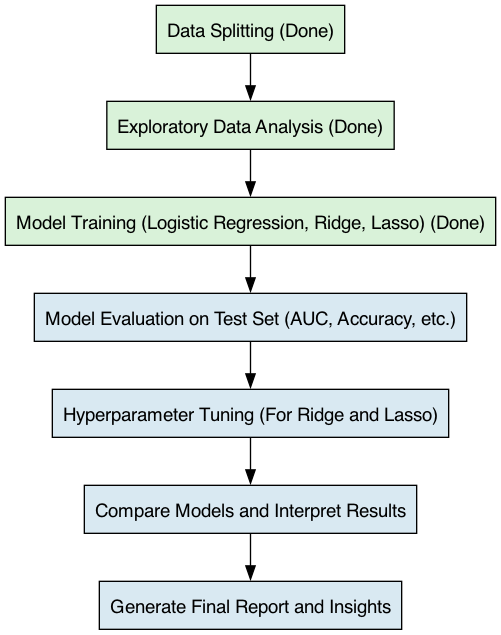

